# Ctypes con estructuras

En apuntes anteriores de ctypes se hizo un enlace usando los numpy arrays. En estos apuntes, se muestra como crear un enlace con estructuras definidas en C.

## Dependencias

In [1]:
from ctypes import *

In [2]:
import numpy as np

Esta función auxiliar permite realizar el enlace formal, sin tener que repetir procedimientos.

In [3]:
def set_function(lib, funcname, argtypes, restype):
    func = lib.__getattr__(funcname)
    func.argtypes = argtypes
    func.restype = restype
    return func

## Librería para hacer operaciones ariméticas con matrices

In [4]:
%%file matrixlib.c
#include <math.h>
#include <time.h>
#include <stdio.h>
#include <stdlib.h>

typedef struct matrix matrix;

struct matrix
{
    int m;
    int n;
    double *arr;
};

matrix creatematrix(int m, int n)
{
    matrix ret;
    ret.m = m;
    ret.n = n;
    double *arr = (double *)malloc(sizeof(double) * m * n);
    ret.arr = arr;
    return ret;
}

matrix randmatrix(int m, int n)
{
    matrix R = creatematrix(m, n);
    double ele = 0.0;
    double den = sqrt(2.0);
    for (int i = 0; i < m * n; i++)
    {
        ele = (double)rand();
        R.arr[i] = (sin(ele)+cos(ele))/den;
    }
    return R;
}

matrix copymatrix(matrix A)
{
    int m = A.m;
    int n = A.n;
    matrix B = creatematrix(m, n);
    for (int i = 0; i < m * n; i++)
    {
        B.arr[i] = A.arr[i];
    }
    return B;
}

matrix zerosmatrix(int m, int n)
{
    matrix B = creatematrix(m, n);
    for (int i = 0; i < m * n; i++)
    {
        B.arr[i] = 0.0;
    }
    return B;
}

matrix zeroslikematrix(matrix A)
{
    return zerosmatrix(A.m, A.n);
}

matrix onesmatrix(int m, int n)
{
    matrix B = creatematrix(m, n);
    for (int i = 0; i < m * n; i++)
    {
        B.arr[i] = 1.0;
    }
    return B;
}

matrix oneslikematrix(matrix A)
{
    return onesmatrix(A.m, A.n);
}

matrix eyematrix(int m, int n)
{
    matrix I = zerosmatrix(m, n);
    for (int i = 0; i < m; i++)
    {
        for (int j = 0; j < n; j++)
        {
            if (i == j)
            {
                I.arr[i*n + j] = 1.0;
            }
        }
    }
    return I;
}

matrix negmatrix(matrix A)
{
    int m = A.m;
    int n = A.n;
    matrix B = creatematrix(m,n);
    for (int i = 0; i < m * n; i++)
    {
        B.arr[i] = -A.arr[i];
    }
    return B;
}

matrix addmatrix(matrix A, matrix B)
{
    int m = A.m;
    int n = A.n;
    matrix C = creatematrix(m, n);
    for (int i = 0; i < m * n; i++)
    {
        C.arr[i] = A.arr[i] + B.arr[i];
    }
    return C;
}

matrix submatrix(matrix A, matrix B)
{
    int m = A.m;
    int n = A.n;
    matrix C = creatematrix(m, n);
    for (int i = 0; i < m * n; i++)
    {
        C.arr[i] = A.arr[i] - B.arr[i];
    }
    return C;
}

matrix scalmatprod(matrix s, matrix X)
{    
    int m = X.m;
    int n = X.n;
    matrix R = creatematrix(m, n);
    double alpha = s.arr[0];
    for (int i = 0; i < m*n; i++)
    {
        R.arr[i] = alpha*(X.arr[i]);
    }
    return R;
}

matrix innerprod(matrix x, matrix y)
{    
    int n = x.n;
    matrix d = creatematrix(1, 1);
    double s = 0.0;
    for (int i = 0; i < n; i++)
    {
        s += (x.arr[i])*(y.arr[i]);
    }
    d.arr[0] = s;
    return d;
}

matrix outerprod(matrix u, matrix v)
{    
    int m = u.m;
    int n = v.n;
    matrix o = creatematrix(m, n);
    
    for (int i = 0; i < m; i++)
    {
        for (int j = 0; j < n; j++)
        {
            o.arr[i*n + j] = u.arr[i]*v.arr[j];
        }
    }
    return o;
}

matrix matvecprod(matrix A, matrix x)
{    
    int m = A.m;
    int n = A.n;
    matrix b = creatematrix(m, 1);
    double s = 0.0;
    for (int i = 0; i < m; i++)
    {
        s = 0.0;
        for (int j = 0; j < n; j++)
        {
            s += (A.arr[i*n + j])*(x.arr[j]);
        }
        b.arr[i] = s;
    }
    return b;
}

matrix matmatprod(matrix A, matrix B)
{
    int i, j, k;
    matrix C = zerosmatrix(A.m, B.n);
    for (i = 0; i < (A.m); i++)
    {
        for (k = 0; k < (A.n); k++)
        {
            for (j = 0; j < (B.n); j++)
            {
                C.arr[i * (B.n) + j] += (A.arr[i * (A.n) + k]) * (B.arr[j + k * (B.n)]);
            }
        }
    }
    return C;
}

matrix mulmatrix(matrix A, matrix B)
{
    if (((A.m) == 1) && ((A.n) == 1))
    {
        return scalmatprod(A,B);
    }
    
    if (((B.m) == 1) && ((B.n) == 1))
    {
        return scalmatprod(B,A);
    }

    if (((A.m) == 1) && ((A.n) == (B.m)) && ((B.n) == 1))
    {
        return innerprod(A,B);
    }
    
    if (((A.n) == 1) && ((B.m) == 1))
    {
        return outerprod(A,B);
    }
    
    if (((A.n) == (B.m)) && ((B.n) == 1))
    {
        return matvecprod(A,B);
    }
    
    if ((A.n) == (B.m))
    {
        return matmatprod(A,B);
    }
    
    return zerosmatrix(1,1);
}

matrix scalmatdiv(matrix s, matrix A)
{
    int m = A.m;
    int n = A.n;
    matrix C = creatematrix(m, n);
    double scal = s.arr[0];
    for(int i = 0; i < m * n; i++)
    {
        C.arr[i] = scal/A.arr[i];
    }
    return C;
}

matrix matscaldiv(matrix A, matrix s)
{
    int m = A.m;
    int n = A.n;
    matrix C = creatematrix(m, n);
    double scal = s.arr[0];
    for(int i = 0; i < m * n; i++)
    {
        C.arr[i] = A.arr[i]/scal;
    }
    return C;
}

matrix matmatdiv(matrix A, matrix B)
{
    int m = A.m;
    int n = A.n;
    matrix C = creatematrix(m, n);
    for(int i = 0; i < m * n; i++)
    {
        C.arr[i] = (A.arr[i])/(B.arr[i]);
    }
    return C;
}

matrix divmatrix(matrix A, matrix B)
{
    if (((A.m) == 1) && ((A.n) == 1))
    {
        return scalmatdiv(A,B);
    }
    
    if (((B.m) == 1) && ((B.n) == 1))
    {
        return matscaldiv(A,B);
    }
    
    if (((A.m) == (B.m)) && ((A.n) == (B.n)))
    {
        return matmatdiv(A,B);
    }
    
    return zerosmatrix(1,1);
}

matrix transposematrix(matrix A)
{
    int m = A.m;
    int n = A.n;
    matrix T = creatematrix(n, m);
    for (int i = 0; i < m; i++)
    {
        for (int j = 0; j < n; j++)
        {
            T.arr[j * m + i] = A.arr[i * n + j];
        }
    }
    return T;
}

matrix norm2matrix(matrix A)
{    
    matrix R = zerosmatrix(1,1);
    int m = A.m;
    int n = A.n;
    double s = 0.0;
    for (int i = 0; i < m*n; i++)
    {
        s += (A.arr[i])*(A.arr[i]);
    }
    R.arr[0] = sqrtf(s);
    return R;
}

Writing matrixlib.c


In [5]:
! gcc -c -fpic -O3 matrixlib.c -o matrixlib.o -lm
! gcc -shared matrixlib.o -o matrixlib.so

In [6]:
matrixlib = CDLL('./matrixlib.so')

In [7]:
class matrix(Structure):
    _fields_ = [
        ('m', c_int),
        ('n', c_int),
        ("arr", POINTER(c_double))
    ]
    
    def __init__(self, m, n, name="zeros"):
        self.m, self.n = m, n 
        self.arr = (c_double * (m * n))()
        if name == "random":
            self.arr = randmatrix(m, n).arr
        elif name == "eye":
            self.arr = eyematrix(m, n).arr
        elif name == "ones":
            self.arr = onesmatrix(m, n).arr
        else:
            self.arr = zerosmatrix(m, n).arr
    
    # para ver un formato de los datos en la salida
    def __repr__(self):
        m = self.m
        n = self.n
        data = self.arr

        mat = []
        if (n > 5):
            for i in range(m):
                row = []
                for j in range(4):
                    row.append(str(data[i*n+j]))
                row.append('...')
                row.append(str(data[i*n+m-1]))
                mat.append(row)
            return '\n'.join(['\t'.join(str(c) for c in row) for row in mat])
        
        for i in range(m):
            row = []
            for j in range(n):
                row.append(data[i*n+j])
            mat.append(row)
        return '\n'.join(['\t'.join(str(c) for c in row) for row in mat])
    
    # para hacer a[i,j] = val o a[ind] = val
    def __setitem__(self, index, value):
        m = self.m
        n = self.n        
        if isinstance(index, tuple):
            i, j = index
            self.arr[i*n + j] = value
        else:
            self.arr[index] = value

    # para ver el valor a[i,j] o a[ind]
    def __getitem__(self, args):
        m = self.m
        n = self.n        
        if isinstance(args, tuple):
            i, j = args
            return self.arr[i*n + j]
        return self.arr[args]
    
    # para saber la cantidad de elementos
    def __len__(self):
        return self.m * self.n
    
    # para sumar 
    def __add__(self,B):
        return addmatrix(self,B)

    # para restar
    def __sub__(self,B):
        return submatrix(self,B)
    
    # para multiplicar
    def __mul__(self,B):
        return mulmatrix(self,B)
    
    # para dividir con coma flotante
    def __truediv__(self,B):
        return divmatrix(self,B)
    
    # para invetir el signo de los elementos
    def __invert__(self):
        return negmatrix(self)
    
    # para saber las dimensiones
    def shape(self):
        return (self.m, self.n)
    
    # para calcular la transpuesta
    def T(self):
        return transposematrix(self)

Las funciones de la librería

In [8]:
randmatrix = set_function(matrixlib,'randmatrix',[c_int, c_int],matrix)
zerosmatrix = set_function(matrixlib,'zerosmatrix',[c_int, c_int],matrix)
onesmatrix = set_function(matrixlib,'onesmatrix',[c_int, c_int],matrix)
addmatrix = set_function(matrixlib,'addmatrix',[matrix,matrix],matrix)
submatrix = set_function(matrixlib,'submatrix',[matrix,matrix],matrix)
mulmatrix = set_function(matrixlib,'mulmatrix',[matrix,matrix],matrix)
divmatrix = set_function(matrixlib,'divmatrix',[matrix,matrix],matrix)
negmatrix = set_function(matrixlib,'negmatrix',[matrix],matrix)
copymatrix = set_function(matrixlib,'copymatrix',[matrix],matrix)
zeroslikematrix = set_function(matrixlib,'zeroslikematrix',[matrix],matrix)
oneslikematrix = set_function(matrixlib,'oneslikematrix',[matrix],matrix)
eyematrix = set_function(matrixlib,'eyematrix',[c_int, c_int],matrix)
transposematrix = set_function(matrixlib,'transposematrix',[matrix],matrix)
norm2matrix = set_function(matrixlib,'norm2matrix',[matrix],matrix)

## Prueba de la clase y la librería

Una matriz de dos filas y tres columnas cuyos elementos son ceros.

In [9]:
A = matrix(2,3,name="zeros")
A

0.0	0.0	0.0
0.0	0.0	0.0

Una matriz de dos filas y tres columnas cuyos elementos son números aleatorios entre -1 y 1

In [10]:
A = matrix(2,3,name="random")
A

-0.963365078409512	-0.11508608588968523	0.5779696421830516
0.7167340089935325	0.9866952167154839	0.30926539733452424

Una matriz de dos filas y tres columnas cuyos elementos son unos.

In [11]:
A = matrix(2,3,name="ones")
A

1.0	1.0	1.0
1.0	1.0	1.0

Modificación del tercer elemento.

In [12]:
A[3] = 4.0
A

1.0	1.0	1.0
4.0	1.0	1.0

Modificación del elemento en la fila 0 y columna 0.

In [13]:
A[0,0] = 5.0
A

5.0	1.0	1.0
4.0	1.0	1.0

Leer el elemento de índice 0

In [14]:
A[0]

5.0

Leer el elemento en la fila 0 y columna 1

In [15]:
A[0,1]

1.0

Cantidad de elementos

In [16]:
len(A)

6

In [17]:
B = matrix(2,3,name="ones")
B

1.0	1.0	1.0
1.0	1.0	1.0

Filas y columnas de B

In [18]:
B.m, B.n

(2, 3)

In [19]:
B.shape()

(2, 3)

Sumar A y B

In [20]:
C = A + B
C

6.0	2.0	2.0
5.0	2.0	2.0

Restar A y B

In [21]:
D = A - B
D

4.0	0.0	0.0
3.0	0.0	0.0

In [22]:
C

6.0	2.0	2.0
5.0	2.0	2.0

In [23]:
D

4.0	0.0	0.0
3.0	0.0	0.0

Sumar los resultados parciales

In [24]:
E = C + D
E

10.0	2.0	2.0
8.0	2.0	2.0

In [25]:
B = matrix(3,2,name="ones")
B

1.0	1.0
1.0	1.0
1.0	1.0

Una matriz de ceros con las mismas dimensiones que B

In [26]:
zeroslikematrix(B)

0.0	0.0
0.0	0.0
0.0	0.0

La transpuesta de B

In [27]:
B.T()

1.0	1.0	1.0
1.0	1.0	1.0

In [28]:
transposematrix(B)

1.0	1.0	1.0
1.0	1.0	1.0

Una matriz de cero con las mismas dimensiones que la transpuesta de B

In [29]:
zeroslikematrix(B.T())

0.0	0.0	0.0
0.0	0.0	0.0

Producto de A y B (matriz por matriz)

In [30]:
F = A * B
F

7.0	7.0
6.0	6.0

Llenar B con el mismo elemento

In [31]:
B = matrix(2,3)
for i in range(2):
    for j in range(3):
        B[i,j] = 2.0
B

2.0	2.0	2.0
2.0	2.0	2.0

Dividir A y B elemento a elemento

In [32]:
C = A / B
C

2.5	0.5	0.5
2.0	0.5	0.5

Invertir el signo de A

In [33]:
~A

-5.0	-1.0	-1.0
-4.0	-1.0	-1.0

Una matriz identidad

In [34]:
I = matrix(3,3,"eye")
I

1.0	0.0	0.0
0.0	1.0	0.0
0.0	0.0	1.0

La transpuesta de la matriz identidad es igual a la identidad

In [35]:
I.T()

1.0	0.0	0.0
0.0	1.0	0.0
0.0	0.0	1.0

Una matriz multiplicada por la matriz identidad devuelve la misma matriz.

In [36]:
A * I

5.0	1.0	1.0
4.0	1.0	1.0

In [37]:
I.T() * A.T()

5.0	4.0
1.0	1.0
1.0	1.0

Matriz de unos con las mismas dimensiones que el producto

In [38]:
oneslikematrix(I.T() * A.T())

1.0	1.0
1.0	1.0
1.0	1.0

La primera columna de la identidad

In [39]:
I = matrix(3,1,"eye")
I

1.0
0.0
0.0

Se puede conservar la primera columna de esta forma

In [40]:
A * I

5.0
4.0

Matriz fila:

In [41]:
rv = matrix(1,4,"random")
rv

0.983600885228758	-0.727800972851546	-0.06579034779638843	-0.6416964775221091

Matriz columna:

In [42]:
cv = matrix(4,1,"random")
cv

0.06514321346465243
0.9961535682614354
0.562496589060558
0.9415646214313625

Su producto es equivalente al producto interno.

In [43]:
rv * cv

-1.3021321608202534

En el orden contrario sería el producto externo.

In [44]:
cv * rv

0.06407492243047808	-0.04741129413424997	-0.004285794670413857	-0.041802170614738295
0.9798175315657339	-0.7250015360902117	-0.0655372897145332	-0.639228235824443
0.5532721429381218	-0.4093855647439504	-0.037006846228576286	-0.3609520798183614
0.9261237951399686	-0.6852716474803433	-0.06194586391674414	-0.6041987009319435

Comparación con Numpy en tiempo de ejecución.

In [45]:
n = 1024
a = np.random.rand(n,n)
b = np.random.rand(n,n)

In [46]:
%timeit -r 3 -n 3 c = np.dot(a,b)

46.3 ms ± 4.84 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [47]:
A = matrix(n,n,"random")
B = matrix(n,n,"random")

In [48]:
%timeit -r 3 -n 3 C = A * B

471 ms ± 6.06 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


Muy lejos de numpy :'v

## Implementación del método Gradiente Conjugado con la clase

In [49]:
n = 512
M = matrix(n,n,"random")
I = matrix(n,n,"eye")
s = matrix(n,1,"random")
A = (M.T() * M) + I
b = A*s

In [50]:
def conjgradmeth(A,b,tol):
    nb = norm2matrix(b)
    x = zeroslikematrix(b)
    r = b
    p = r 
    ro = r.T() * r
    e = []
    ind = []
    for i in range(len(b)):
        Ap = A*p
        alpha = ro / (p.T() * Ap)
        x = x + alpha*p
        r = r - alpha*Ap
        rn = r.T() * r
        err = rn / nb
        e.append(err[0])
        ind.append(i)
        if (err[0] < tol):
            break
        p = r + (rn / ro) * p
        ro = rn
    return x, ind, e

In [51]:
x, ind, e = conjgradmeth(A,b,1e-10)
norm2matrix(x-s)/norm2matrix(s)

5.0719140984662076e-06

In [52]:
import matplotlib.pyplot as plt

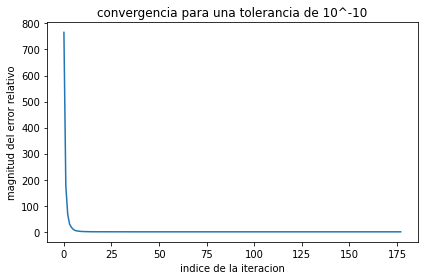

In [53]:
plt.plot(ind, e)
plt.title('convergencia para una tolerancia de 10^-10')
plt.xlabel('indice de la iteracion')
plt.ylabel('magnitud del error relativo')
plt.tight_layout()

Se puede realizar un acercamiento luego de las primeras 20 iteraciones para obvervar con mayor detalle el cambio en el error relativo.

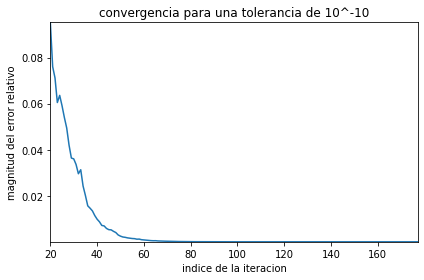

In [54]:
plt.plot(ind, e)
plt.title('convergencia para una tolerancia de 10^-10')
plt.xlabel('indice de la iteracion')
plt.ylabel('magnitud del error relativo')
plt.xlim(ind[20], ind[-1])
plt.ylim(e[-1], e[20])
plt.tight_layout()

In [55]:
! rm matrixlib.c
! rm matrixlib.o
! rm matrixlib.so